In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.special import erf
from scipy.stats import norm, gamma, ttest_ind, wilcoxon
import math
import warnings
import matplotlib.pyplot as plt
from scipy.special import erf
warnings.simplefilter(action='ignore')
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.5f}'.format})
#from MarketMix_HMC_1g_May_2021 import MarketMixModel
# from MaxLikelihood_1g_May_2021 import LK_MLE

In [2]:
#w = 104; w1 = 52
w = 52
# generate spend from a normal distribution with mean 1000 and std 100
# set seed for reproducibility
np.random.seed(2024)
# spend1 = np.random.normal(1000, 100, w1)
# spend2 = np.random.normal(1000, 100, 20)*1.4
# spend3 = np.random.normal(1000, 100, w - w1 - 20)
# combine the above into one names as speed
# spend = np.concatenate([spend1, spend2, spend3])
np.random.seed(2024)
spend = np.random.normal(1000, 100, w)
L = 5


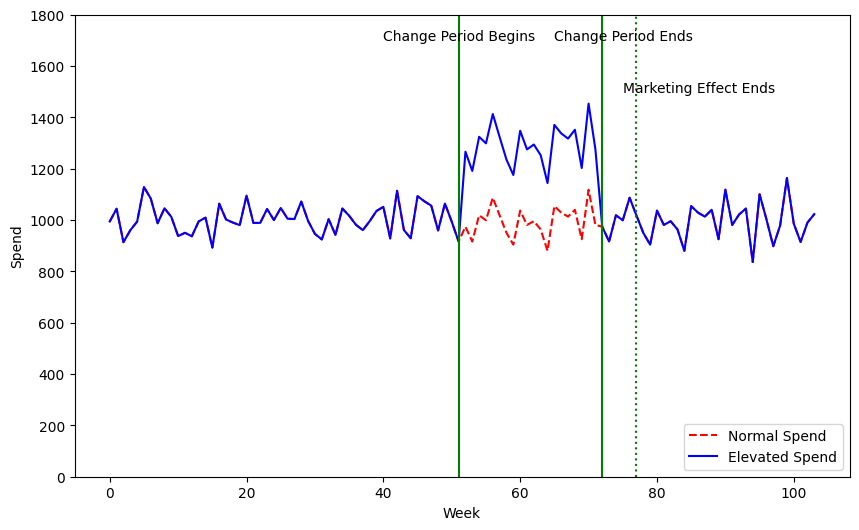

In [14]:
# let's generate data
# sd
sd1 = 60
#
w1 = 52
w2 = 20
w3 = 32
w = w1 + w2 + w3
np.random.seed(2025)
spend1 = np.random.normal(1000, sd1, w1)
#spend2_yes = np.random.normal(1200, 100, w2)
np.random.seed(2026)
spend2_no = np.random.normal(1000, sd1, w2)
np.random.seed(2026)
spend3 = np.random.normal(1000, sd1, w3)
#combine
spend = np.concatenate([spend1, 1.3*spend2_no, spend3])
spend_no = np.concatenate([spend1, spend2_no, spend3])
# plot the two spend, one line for each spend, spend is solid black line, spend_no is dashed black line
plt.figure(figsize=(10, 6))
plt.plot(spend_no, label='Normal Spend', color='red', linestyle='dashed')
plt.plot(spend, label='Elevated Spend', color='blue')
# x lable is week
plt.xlabel('Week')
# y label is spend
plt.ylabel('Spend')
# add a vertical line at x = 52
plt.axvline(x=51, color='green', linestyle='solid')
# add a text at x = 52, y = 1100
plt.text(40, 1700, 'Change Period Begins', color='black')
plt.text(65, 1700, 'Change Period Ends', color='black')
# 65+L(5)
plt.text(75, 1500, 'Marketing Effect Ends', color='black')
# add a vertical line at x = 72
plt.axvline(x=72, color='green', linestyle='solid')
# 72+L(5)
plt.axvline(x=77, color='green', linestyle='dotted')
# ylim is 0 to 1000
plt.ylim(0, 1800)
plt.legend(loc = 'lower right')
plt.show()

In [4]:
# the spend_st is the observed spend
seasonality = 100 * np.sin(2 * math.pi * np.arange(w) / 52) 
#
trend = 1*np.arange(w)
#
# combine spend, seasonality and trend by row to form a pd dataframe
df = pd.DataFrame({'spend': spend, 'seasonality': seasonality, 'trend': trend})

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['spend'], label='spend')
plt.plot(df['seasonality'], label='seasonality')
plt.plot(df['trend'], label='trend')
plt.legend()
plt.show()

In [6]:
##### get the diag chunk
def power_chen(alpha, k):
    seq_l = np.linspace(k, 0, k+1)
    tem = alpha**seq_l
    return tem

In [7]:
n = len(spend)
#L = 13
spend_s = np.zeros(n)
for i in range(len(spend)):
    if i < L:
        # subset the first i spend
        spend_sub = spend[:i+1]
        #power_chen(alpha = 0.5, i) * spend_sub
        spend_s[i] = np.sum(power_chen(alpha = 0.6, k = i) * spend_sub)
    else:
        spend_sub = spend[i-L:i+1]
        spend_s[i] = np.sum(power_chen(alpha = 0.6, k = L) * spend_sub)

In [ ]:
# plot spend and spend_s
plt.figure(figsize=(12, 6))
plt.plot(spend, label='spend')
plt.plot(spend_s, label='spend_s')
plt.legend()
plt.show()

In [ ]:
# let's do a scaling on spend_s
spend_s1 = spend_s/1000
#
# now let's do a Hill function on spend_s
spend_trans = 1/(1 + (spend_s1/1)**(-2))
# scale back
spend_trans = spend_trans*1000

# now we can compute y 
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.5f}'.format})
# generate z from a uniform distribution
np.random.seed(2025)
z1 = np.random.uniform(100, 200, w)
np.random.seed(2029)
z2 = np.random.uniform(20, 80, w)
# set seed
np.random.seed(2025)
y = 1 + 1.5*spend_trans + 0.1*seasonality + 0.2*trend + 1*z1 + 1*z2 + np.random.normal(0, 10, w)
# now let's compute the true ROI and the true lift
# the total spend in that 20 weeks
#total_spend = spend[w1:w1+20].sum()
total_spend = spend.sum()
# total reward in that 20 weeks
# compute y_bar without spend
y_bar = 1 + 0.1*seasonality + 0.2*trend + 1*z1 + 1*z2
# compute the difference in that 20 weeks
# diff = (y[w1:w1+20+L] - y_bar[w1:w1+20+L]).sum()
diff = (y - y_bar).sum()
#
roi = (diff - total_spend)/total_spend
print('The true ROI is', roi)

In [ ]:
# let's combine spend, seasonality, trend, z and y into a pd dataframe
df = pd.DataFrame({'spend': spend, 'seasonality': seasonality, 'trend': trend, 'z1': z1, 'z2':z2, 'y': y})
df.head(5)

In [ ]:
df.shape

In [21]:
# write out df as a csv file
df.to_csv('df_ch1.csv', index=False)

In [ ]:
#raise SystemExit('Stop right there!')

In [ ]:
# simulate x from 0 to 2 
x = np.linspace(0, 2, 100)
y1 = 1/(1 + (x/0.1)**(-2))
y2 = 1/(1 + (x/0.5)**(-2))
y3 = 1/(1 + (x/0.8)**(-2))
y4 = 1/(1 + (x/1)**(-2))
y5 = 1/(1 + (x/2)**(-2))
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label='K=0.1')
plt.plot(x, y2, label='K=0.5')
plt.plot(x, y3, label='K=0.8')
plt.plot(x, y4, label='K=1')
plt.plot(x, y5, label='K=2')
plt.legend()
plt.show()

In [ ]:
# simulate x from 0 to 2 
x = np.linspace(0, 2, 100)
y1 = 1/(1 + (x/0.5)**(-0.5))
y2 = 1/(1 + (x/1)**(-0.5))
y3 = 1/(1 + (x/1.5)**(-0.5))
y4 = 1/(1 + (x/2)**(-0.5))
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label='K=0.5')
plt.plot(x, y2, label='K=1')
plt.plot(x, y3, label='K=1.5')
plt.plot(x, y4, label='K=2')
plt.legend()
plt.show()

In [16]:
# # simulate x from 0 to 2 
# x = np.linspace(0, 2, 100)
# y1 = 1/(1 + (x/1)**(-0.5))
# y2 = 1/(1 + (x/0.5)**(-0.5))
# y3 = 1/(1 + (x/2)**(-0.5))
# plt.figure(figsize=(12, 6))
# plt.plot(x, y1, label='K=1')
# plt.plot(x, y2, label='K=0.5')
# plt.plot(x, y3, label='K=2')
# plt.legend()
# plt.show()

In [ ]:
# Example value
x = 2

# Compute the error function
erf_value = erf(x)
print(f'The error function value at {x} is {erf_value}')

In [37]:
# Weibull CDF 
def weibull_cdf(x, lam, k):
    return 1 - np.exp(-(x/lam)**k)

In [ ]:
x = np.linspace(0, 5, 100)
K = 0.5
y1 = weibull_cdf(x, lam = 0.1, k = K)
y2 = weibull_cdf(x, lam = 0.5, k = K)
y3 = weibull_cdf(x, lam = 0.8, k = K)
y4 = weibull_cdf(x, lam = 1, k = K)
y5 = weibull_cdf(x, lam = 1.5, k = K)
y6 = weibull_cdf(x, lam = 2, k = K)
y7 = weibull_cdf(x, lam = 4, k = K)
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label='K=0.1')
plt.plot(x, y2, label='K=0.5')
plt.plot(x, y3, label='K=0.8')
plt.plot(x, y4, label='K=1')
plt.plot(x, y5, label='K=1.5')
plt.plot(x, y6, label='K=2')
plt.plot(x, y7, label='K=4')
plt.legend()
plt.show()

In [ ]:
x = np.linspace(0, 5, 100)
K = 2
y1 = weibull_cdf(x, lam = 0.1, k = K)
y2 = weibull_cdf(x, lam = 0.5, k = K)
y3 = weibull_cdf(x, lam = 0.8, k = K)
y4 = weibull_cdf(x, lam = 1, k = K)
y5 = weibull_cdf(x, lam = 1.5, k = K)
y6 = weibull_cdf(x, lam = 2, k = K)
y7 = weibull_cdf(x, lam = 4, k = K)
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label='K=0.1')
plt.plot(x, y2, label='K=0.5')
plt.plot(x, y3, label='K=0.8')
plt.plot(x, y4, label='K=1')
plt.plot(x, y5, label='K=1.5')
plt.plot(x, y6, label='K=2')
plt.plot(x, y7, label='K=4')
plt.legend()
plt.show()